In [2]:
import itertools
from time import sleep
import numpy as np
import os
import pandas as pd
import re
import pathlib
import csv
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.metrics import precision_score
import shutil
import soundfile as sf
import matplotlib.pyplot as plt
import librosa

In [4]:
DATASET_ROOT = os.path.join(os.path.expanduser("~"),'dataSet/audio/agender_distribution/')
NETWORK_ROOT = os.path.join(os.path.expanduser("~"),'Mestrado-PC/github/Conv1D/CNN/')

In [5]:
wav_file= DATASET_ROOT + 'wav_traindevel/1001/2/a11001s10.wav'
[signal, fs] = librosa.load(os.path.join(DATASET_ROOT, wav_file), sr= 8000, mono=True)

In [4]:
wav_file= DATASET_ROOT + 'wav_traindevel/1001/2/a11001s10.wav'
[signal, fs] = sf.read(wav_file)

In [6]:
len(signal), len(signal.shape)

(29696, 1)

In [7]:
np.abs(signal)

array([0.00024414, 0.00219727, 0.00024414, ..., 0.00024414, 0.00024414,
       0.00024414], dtype=float32)

In [8]:
np.max(np.abs(signal))

0.984375

In [8]:
duration = len(signal)/fs
time = np.arange(0,duration,1/fs)

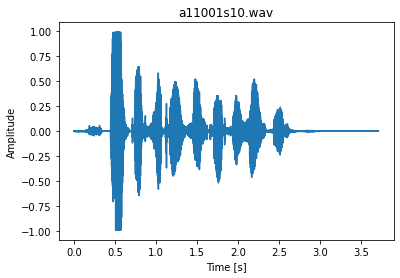

In [10]:
plt.plot(time,signal)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('a11001s10.wav')
plt.show()

In [11]:
signaln=signal/np.max(np.abs(signal))

In [12]:
signaln

array([-0.00024802,  0.00223214, -0.00024802, ..., -0.00024802,
       -0.00024802, -0.00024802])

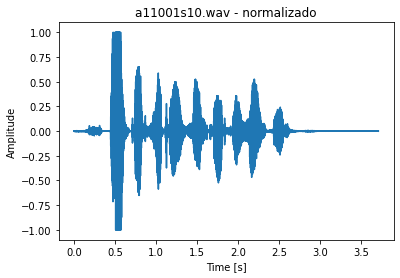

In [13]:
plt.plot(time,signaln)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('a11001s10.wav - normalizado')
plt.show()

In [14]:
np.max(np.abs(signaln))

1.0

In [15]:
sf.write('signaln.wav', signaln, fs)